In [1]:
'''
    PAQUETES UTILIZADOS
'''
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from calendar import monthrange
%matplotlib inline

In [8]:
'''
    FUNCION leeBD
    Regresa la base de datos "base" con valores numéricos
'''
def leeBD():
    # Lectura de la base de datos
    #base = pd.read_csv('OnlineNewsPopularity-Modified.csv', sep=",")
    base = pd.read_csv('OnlineNewsPopularity-Modified.csv', sep=",")
    base = base.copy()

    # Convertir dia de la semana de str a num 
    # Lunes es el 0
    weekdays = np.array(base.weekday.unique())
    for val in weekdays:
        base.ix[base['weekday'] == val, 'weekday'] = np.where(weekdays==val)

    # Convertir tipo de noticias de str a num
    # ['Entertainment', 'Business', 'Tech', 'LifeStyle', 'World', 'Unknown', 'SocMed']
    channels = np.array(base.data_channel.unique())
    for val in channels:
        base.ix[base['data_channel'] == val, 'data_channel'] = np.where(channels==val)  
    
    return base

In [9]:
'''
    FUNCION rangoTimedelta
    Recibe el timedelta de una noticia
    Regresa los valores minimo y maximo del timedelta para acotar una semana, "minDelta" y "maxDelta"
'''
def rangoTimedelta(delta,periodo):
    # Fecha de adquisicion de los datos: January 8, 2015 (Thursday)
    dataAcq = dt.datetime(2015, 1, 8, 0, 0)
    
    # Fecha real de la noticia con base en el timedelta
    fechaNoticia = dataAcq - dt.timedelta(days=delta)
    # Dia de la semana y numero de semana correspondiente a la fecha
    dia = fechaNoticia.weekday()
    semana = fechaNoticia.isocalendar()[1]
    print fechaNoticia, " Dia: ", dia, ", #Semana: ",semana
    
    if periodo == 'semana':
        # Obtener la fecha de inicio y fin de la semana
        inicio = fechaNoticia - dt.timedelta(days=fechaNoticia.weekday())
        fin = inicio + dt.timedelta(days=7)
    else:
        # Obtener la fecha de inicio y fin del mes
        mes = fechaNoticia.month
        anio = fechaNoticia.year
        dias = np.max(monthrange(anio,mes))
        inicio = dt.datetime(anio, mes, 1, 0, 0)
        fin = dt.datetime(anio, mes, dias, 0, 0)

    # Diferencia de fechas entre la noticia y el inicio y fin de semana
    difInicio = fechaNoticia - inicio
    difFin = fin - fechaNoticia
    
    # Obtener timedelta compatible con los valores en la base de datos
    minDelta = delta - difInicio.days
    maxDelta = delta + difFin.days + 1
    
    return minDelta, maxDelta

In [10]:
'''
    FUNCION filtraBD
    Recibe la base de datos "base"
    Regresa una base "base2" filtrada 
'''
def filtraBD(base,delta):
    # Obtener los timedelta correspondientes a la semana de la fecha con timedelta "delta"
    minDelta, maxDelta = rangoTimedelta(delta,'mes')
    
    # Filtrar la base por semana
    rangoFecha = range(minDelta, maxDelta)
    print "Rango timedeltas: ", rangoFecha
    base2 = base.loc[base['timedelta'].isin(rangoFecha)]
    
    return base2

In [11]:
'''
    FUNCION conjEntrenamiento
    Recibe una base de datos "base2"
    Regresa el conjunto de entrenamiento "base_X" y el conjunto objetivo "base_y"
'''
def limpiaDatos(base):
    # Copia de la base sin la primer columna ('url', atributo no predictivo) y sin la variable objetivo
    # Matriz de entrenamiento
    base_X = base.drop(base.columns[[0,1,len(base.columns)-1]], axis=1)

    # Arreglo de valores objetivo (columna de valores objetivo 'shares')
    base_y = np.asarray(base[base.columns[len(base.columns)-1]].tolist())
    
    return base_X, base_y

In [12]:
'''
    FUNCION error_fn
    Recibe el arreglo con valores a predecir "X_predict", el arreglo de valores esperados "y_test"
        y el valor de tolerancia "k"
    Regresa el porcentaje de acierto de la predicción
'''
def error_fn(X_predict, y_test, k):
    i = 0
    yei = 0
    for i in range(len(X_predict)):
        if np.absolute(X_predict[i] - y_test[i]) < k:
            yei = yei + 1
    return yei/float(len(X_predict))

In [13]:
'''
    OBTENCION DE LOS CONJUNTOS DE DATOS Y DE VALORES OBJETIVO
'''
# Lectura de la base de datos
base = leeBD()

# La fecha mas antigua es el 7 de enero del 2013 (timedelta = 731)
# La fecha mas reciente es el 31 de diciembre del 2014 (timedelta = 8)
# El timedelta 372 corresponde al inicio del 2014
delta = 527
print "Timedelta: ", delta

# Filtrado de la base de datos por semana
base2 = filtraBD(base,delta)
print "\nObservaciones totales: ", len(base2)

Timedelta:  527
2013-07-30 00:00:00  Dia:  1 , #Semana:  31
Rango timedeltas:  [498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528]

Observaciones totales:  1611


In [14]:
'''
    OBTENCION DE LOS SUBCONJUNTOS DE ENTRENAMIENTO Y DE PRUEBA
'''
# Separacion de conjuntos entrenamiento y valores objetivo
base_X, base_y = limpiaDatos(base2)

# Obtenemos dos subconjuntos de datos (75% para entrenamiento, 25% para prueba)
# len(X_train) = len(y_train) = 750
# len(X_test) = len(y_test) = 250
# Los índices de ambos conjuntos (train o test) se corresponden de acuerdo a la base de datos original
X_train, X_test, y_train, y_test = train_test_split(base_X, base_y, test_size=0.25)

# Estandarización de los datos con respecto a su subconjunto
X_train = StandardScaler().fit_transform(X_train, y_train)
X_test = StandardScaler().fit_transform(X_test, y_train)

In [15]:
'''
    EJECUCION DEL ALGORITMO PARA ENTRENAR LOS DATOS
'''
# Creación de una instancia de 'Neighbours Classifier'
# Sin atributos, se analizan los datos y se eligen la mejor forma de obtener los k-vecinos
neigh = KNeighborsClassifier()
#neigh = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', n_jobs=-1)

# Entrenamiento de los datos
neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
'''
    PREDICCION CON EL SUBCONJUNTO DE PRUEBA
'''
# Predicción de valores objetivo con el conjunto de prueba
# En teoría, X_test debería ser igual a y_test
X_predict = neigh.predict(X_test)

# Exactitud promedio de la predicción calculada con la librería
accuracy = neigh.score(X_test, y_test)
print 'E: ', accuracy

E:  0.00744416873449


Máximo acierto con k = 400


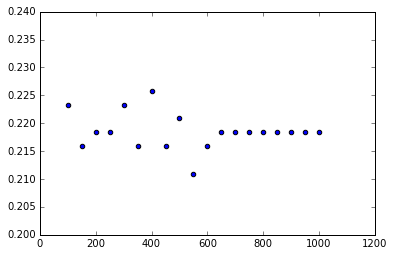

In [17]:
'''
    OBTENCION DE UN K MAXIMO 
    %Acierto vs. K
'''
# Cálculo de error para k vecinos (rango [100 : 50 : 1000])
err_arr = []
arr = np.arange(100, 1050, 50)
for i in arr:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_train,y_train)
    X_predict = neigh.predict(X_test)
    # Rango de tolerancia de 500 vecinos
    err = error_fn(X_predict, y_test, 250)
    err_arr.append(err)

# Graficación de resultados
plt.scatter(arr, err_arr)

# Encontrar el k máximo con esta prueba
maxi = err_arr.index(max(err_arr))
maxi = arr[maxi]
print 'Máximo acierto con k =', maxi

In [18]:
'''
    PRUEBAS DE MARGEN DE ERROR
    Con el k máximo obtenido "maxi"
'''
neigh = KNeighborsClassifier(n_neighbors=maxi, n_jobs=-1)
neigh.fit(X_train,y_train)
X_predict = neigh.predict(X_test)

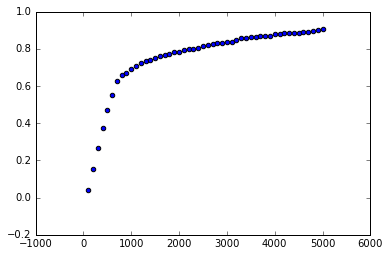

In [19]:
# Margen de error rango [100 : 100 : 2000]
err_arr = []
arr = np.arange(100, 5100, 100)
for i in arr:
    err = error_fn(X_predict, y_test, i)
    err_arr.append(err)
plt.scatter(arr, err_arr)

In [20]:
arr

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300,
       3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
       4500, 4600, 4700, 4800, 4900, 5000])

In [21]:
err_arr

[0.04218362282878412,
 0.15632754342431762,
 0.2679900744416873,
 0.3746898263027295,
 0.47146401985111663,
 0.5508684863523573,
 0.6253101736972705,
 0.6575682382133995,
 0.6724565756823822,
 0.6923076923076923,
 0.707196029776675,
 0.7245657568238213,
 0.7320099255583127,
 0.739454094292804,
 0.749379652605459,
 0.7593052109181141,
 0.7642679900744417,
 0.7741935483870968,
 0.7816377171215881,
 0.7841191066997518,
 0.794044665012407,
 0.7990074441687345,
 0.8014888337468983,
 0.8064516129032258,
 0.8163771712158809,
 0.8213399503722084,
 0.826302729528536,
 0.8337468982630273,
 0.8337468982630273,
 0.8362282878411911,
 0.8362282878411911,
 0.8486352357320099,
 0.8560794044665012,
 0.858560794044665,
 0.8635235732009926,
 0.8660049627791563,
 0.8684863523573201,
 0.8684863523573201,
 0.8709677419354839,
 0.8784119106699751,
 0.8808933002481389,
 0.8833746898263027,
 0.8858560794044665,
 0.8858560794044665,
 0.8858560794044665,
 0.8883374689826302,
 0.8883374689826302,
 0.8957816377171